# NLP Extra Credit- KXP180035

In [1]:
#Importing required libraries
from numpy import array
import keras
from keras.utils import plot_model
import pydot
from tensorflow.keras import backend as K
import keras.backend.common
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#To enter your file just uncomment the below line and comment the 2nd line
#filename=input("Enter you file Name:")
filename='nlp_train.json'
import json

with open(filename) as f:
  data = json.load(f)

print(data)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Preprocessing 

In [3]:
k_dict={}
for key in data:
    a={}
    a[data[key]['body']]=data[key]['emotion']
    k_dict[key]=a
with open('ready.json', 'w') as json_file:
  json.dump(k_dict, json_file)

In [4]:
import csv
inputFile = open('ready.json')
outputFile = open('final.csv', 'w')
data = json.load(inputFile)
inputFile.close() 
output = csv.writer(outputFile)
final_list=[]


def preprocess_text(sen):
   
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

   
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

   
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

output.writerow(["id","body","anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust","neutral"])
for value,key in enumerate(data):
    a=[]
    a.append(key)
    for body in data[key].keys():
        a.append(preprocess_text(body))
        for emotion in data[key][body]:
            e=data[key][body][emotion]
            if e:
                a.append(1)
            else:
                a.append(0)
    output.writerow(a)

In [5]:
file = pd.read_csv("final.csv")
file

,id,body,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,fkrr36o,He was answering question about the criticism ...,1,0,1,0,0,0,0,1,0,0,0,0
1,fjyfp0o,I going to start today discussion thread with ...,1,1,1,1,0,0,0,1,0,0,0,0
2,fibm0x7,By announcing the self quarantined it paints p...,1,1,1,1,0,0,0,1,0,0,0,0
3,fj9b4oj,Likewise sorry if offended you m not actually ...,1,0,1,1,0,0,0,1,0,0,0,0
4,fk04ri5,People infected by experience high fever cough...,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,fk6dgi5,LAUSD Superintendent Beutner gets additional c...,0,0,0,0,0,0,0,0,0,0,0,1
1486,fkehkor,The article for those who run into pay wall am...,0,1,0,1,0,0,1,1,0,0,0,0
1487,fipueyz,At least as for this case in Hokkaido Northern...,0,0,0,0,0,0,0,0,0,0,0,1
1488,fkedc6p,Yes you are correct rd war countries have it p...,1,0,1,1,0,0,0,1,1,0,0,0


In [6]:
filter = file["body"] != ""
file = file[filter]
file = file.dropna()

In [7]:
print(file["body"])

0       He was answering question about the criticism ...
1       I going to start today discussion thread with ...
2       By announcing the self quarantined it paints p...
3       Likewise sorry if offended you m not actually ...
4       People infected by experience high fever cough...
                              ...                        
1485    LAUSD Superintendent Beutner gets additional c...
1486    The article for those who run into pay wall am...
1487    At least as for this case in Hokkaido Northern...
1488    Yes you are correct rd war countries have it p...
1489    The US Government response and won even bother...
Name: body, Length: 1490, dtype: object


In [8]:
file_labels = file[["anger", "anticipation", "disgust", "fear", "joy", "love","optimism","pessimism","sadness","surprise","trust","neutral"]]
file_labels.head()
#File in required input format for model

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,1,0,1,0,0,0,0,1,0,0,0,0
1,1,1,1,1,0,0,0,1,0,0,0,0
2,1,1,1,1,0,0,0,1,0,0,0,0
3,1,0,1,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1


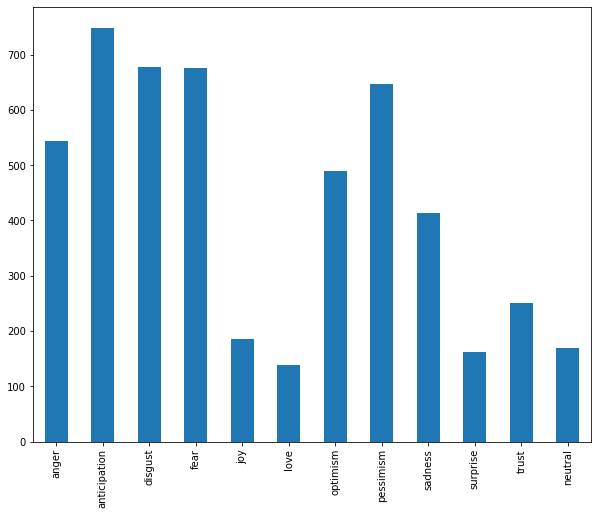

In [9]:
#Distribution of given data

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

file_labels.sum(axis=0).plot.bar()

# Creating Multi-label Text Classification Models

In [10]:
X = []
sentences = list(file["body"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = file_labels.values

In [11]:
#Splitting Train-Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
#Using GloVe word embeddings to convert text inputs to their numeric counterparts.
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [14]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)

In [15]:
# CREATING LSTM MODEL
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(128, activation='relu')(LSTM_Layer_1)
dense_layer_2= Dense(128, activation='sigmoid')(dense_layer_1)
dense_layer_3= Dense(12, activation='relu')(dense_layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_3)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [16]:
#MODEL
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          2493000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 2,644,820
Trainable params: 151,820
Non-trainable params: 2,493,000
___________________________________________

# Model Visualization

In [17]:
from keras.utils import plot_model
import pydot

#import graphviz


## Architecture of our neural network:

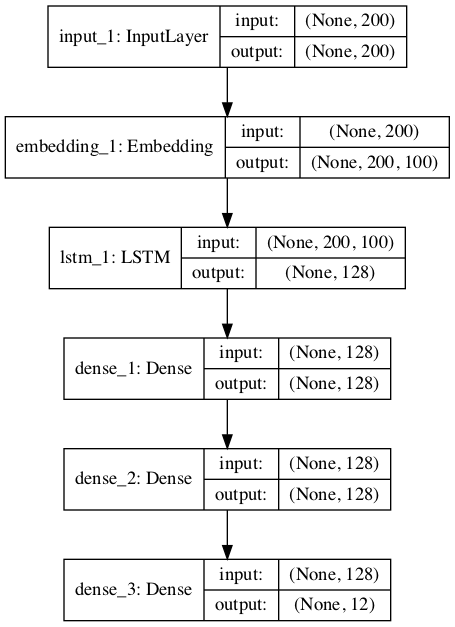

In [18]:
plot_model(model,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [19]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.3)

Train on 834 samples, validate on 358 samples
Epoch 1/30
834/834 [==============================] - 29s 35ms/step - loss: 1.8734 - acc: 0.6121 - val_loss: 1.8312 - val_acc: 0.6660
Epoch 2/30
834/834 [==============================] - 16s 19ms/step - loss: 1.7915 - acc: 0.6690 - val_loss: 1.8469 - val_acc: 0.6553
Epoch 3/30
834/834 [==============================] - 18s 22ms/step - loss: 1.7950 - acc: 0.6598 - val_loss: 1.8378 - val_acc: 0.6487
Epoch 4/30
834/834 [==============================] - 16s 19ms/step - loss: 1.7764 - acc: 0.6809 - val_loss: 1.8108 - val_acc: 0.6972
Epoch 5/30
834/834 [==============================] - 18s 22ms/step - loss: 1.7629 - acc: 0.7078 - val_loss: 1.8035 - val_acc: 0.7027
Epoch 6/30
834/834 [==============================] - 22s 26ms/step - loss: 1.7517 - acc: 0.7140 - val_loss: 1.7998 - val_acc: 0.7072
Epoch 7/30
834/834 [==============================] - 28s 34ms/step - loss: 1.7449 - acc: 0.7208 - val_loss: 1.7953 - val_acc: 0.7246
Epoch 8/30
834/8

In [20]:
score=model.evaluate(X_test,y_test,verbose=1)
print(score[0])
print(score[1])

298/298 [==============================] - 4s 14ms/step
1.7778568083807926
0.735738217830658


## Plotting the loss and accuracy values for training and test sets

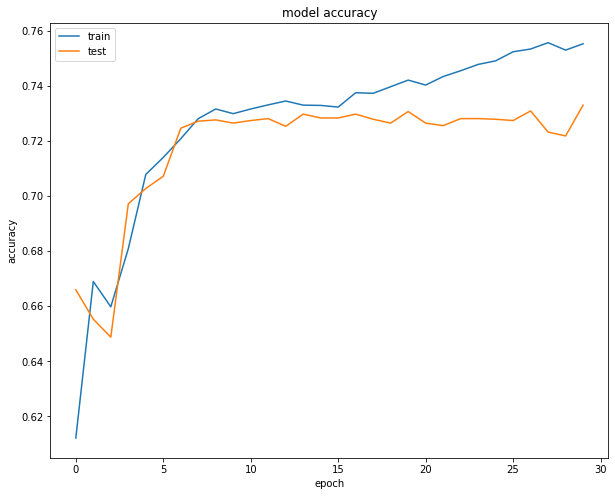

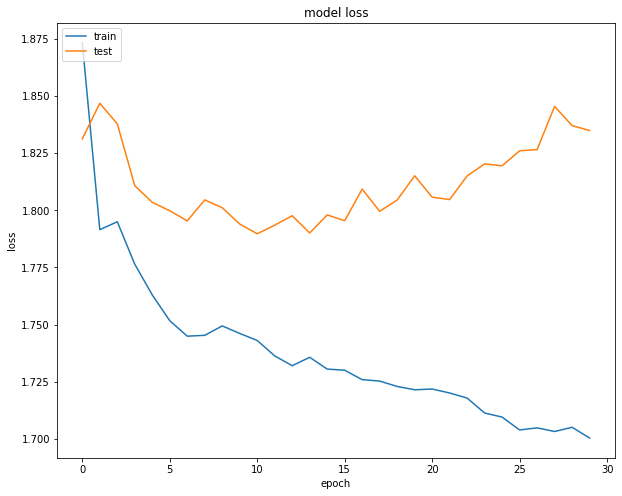

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Test Accuracy: 0.751